<b>Промышленность

<b>Задача: Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

<b>Описание этапа обработки</b>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

<b>Описание данных</b>

Данные состоят из файлов, полученных из разных источников:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

<b>План работы</b>

<p>1) Описание проекта и задачи
<p>2) Выгрузка данных
<p>3) Анализ данных
<p>4) Предобработка данных
<p>5) Работа с проспусками
<p>6) Формирование итоговых датафреймов
<p>7) Формирование целевого и остальных признаков
<p>8) Сформировать обучающую и тестовую выборки
<p>9) Выбрать несколько моделей и проверить их эффективность
<p>10) Эффективность лучшей модели проверить на тестовой выборке
<p>11) Вывод
<p>12) Отчет о проделанной работе

### Загрузка данных

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore') 

RND = 240423

In [2]:
df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_temp = pd.read_csv('/datasets/data_temp_new.csv')
df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

#### Данные об электродах

In [3]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Для вычисления общего времени нагрева поменяем на тип datetime

In [4]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [5]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Посмотрим какое количество итераций встречается

In [6]:
df_arc['key'].value_counts().unique()

array([16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [7]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Поменяем имена столбцов

In [8]:
df_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']

<AxesSubplot:>

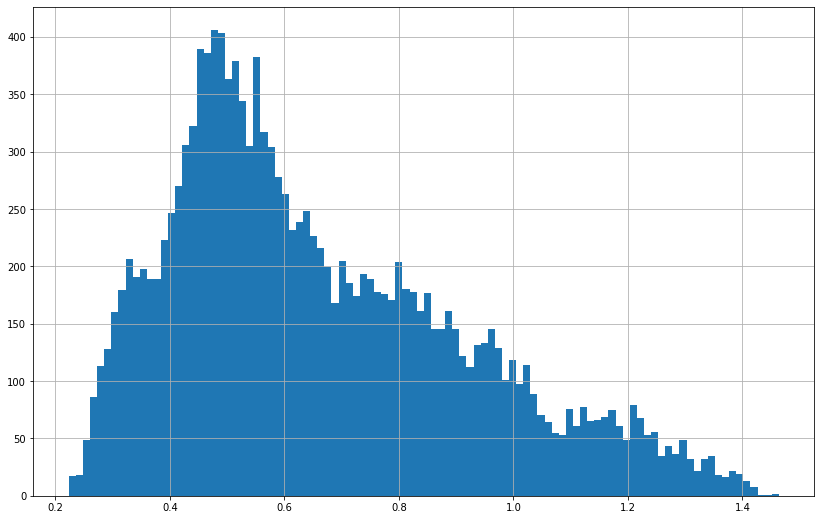

In [9]:
df_arc['active_power'].hist(bins=100, figsize=(14,9))

<AxesSubplot:>

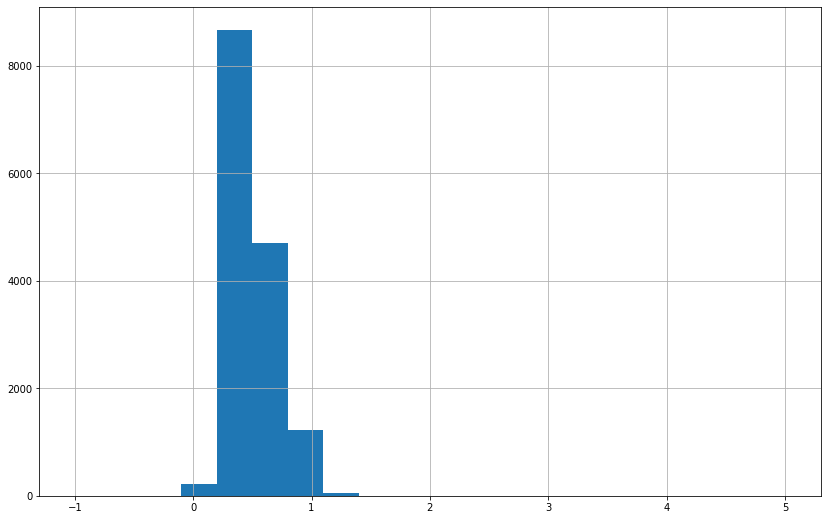

In [10]:
df_arc['reactive_power'].hist(bins=20, figsize=(14,9), range=(-1,5))

In [11]:
df_arc[df_arc['reactive_power'] <= 0]

,key,start_time,end_time,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Есть выброс в данных по реактивной мощности, удалим отрицательное значение

In [12]:
df_arc = df_arc[df_arc['reactive_power'] > 0]

Вычислим время нагрева

In [13]:
df_arc['all_time'] = (df_arc['end_time'] - df_arc['start_time']).dt.seconds

Найдем полную мощность

In [14]:
df_arc['full_power'] = np.sqrt(df_arc['active_power']**2 + df_arc['reactive_power']**2)

Произведем группировку и вычислим сумму всех итераций

In [15]:
df_arc = df_arc.groupby(by = 'key', as_index = False).sum()

In [16]:
df_arc.head()

,key,active_power,reactive_power,all_time,full_power
0,1,3.036730,2.142821,1098,3.718736
1,2,2.139408,1.453357,811,2.588349
2,3,4.063641,2.937457,655,5.019223
3,4,2.706489,2.056992,741,3.400038
4,5,2.252950,1.687991,869,2.816980


#### Данные о подаче сыпучих материалов (объём)

In [17]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [18]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Посмотрим какое количество итераций встречается

In [19]:
df_bulk['key'].value_counts().unique()

array([1])

In [20]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Поменяем имена столбцов

In [21]:
df_bulk.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

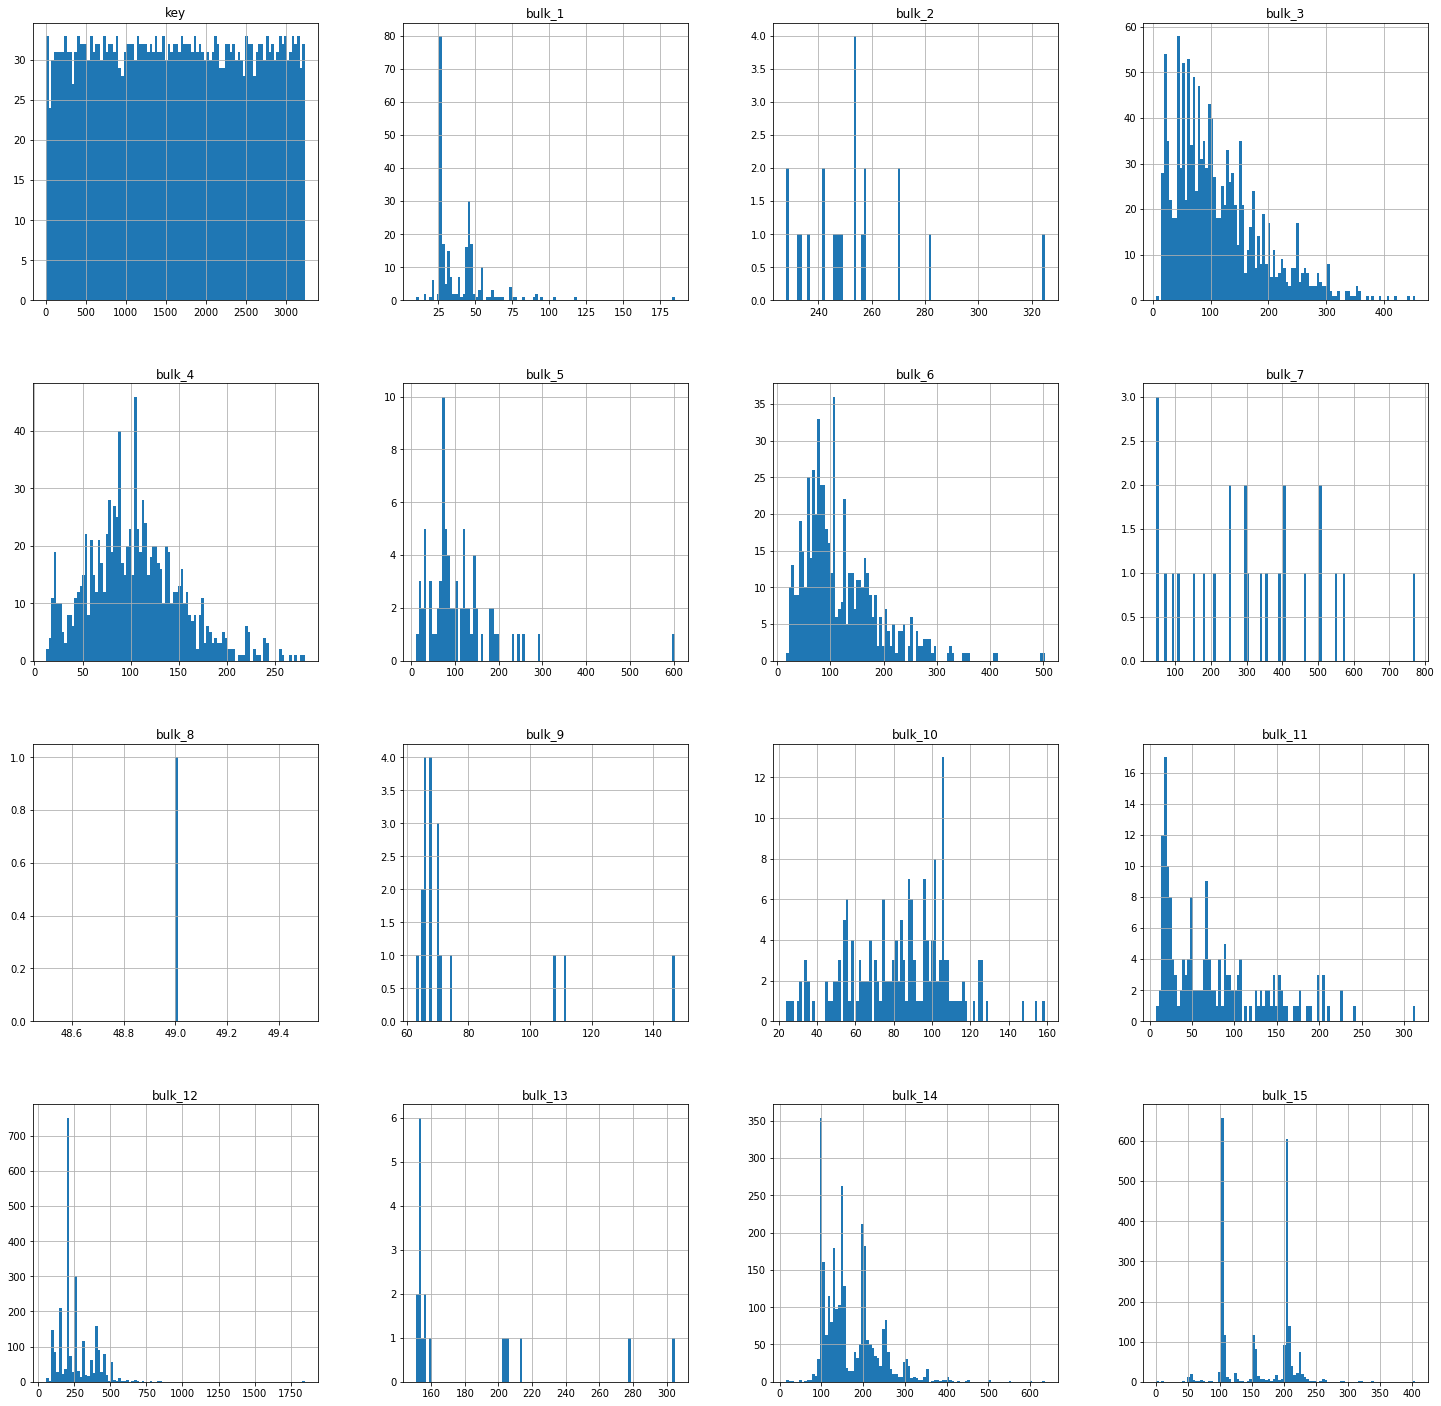

In [22]:
df_bulk.hist(bins=100, figsize=(25,25));

#### Данные о подаче сыпучих материалов (время)

In [23]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [24]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Поменяем имена столбцов

In [25]:
df_bulk_time.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

In [26]:
df_bulk_time['key'].value_counts().unique()

array([1])

#### Данные о продувке сплава газом

In [27]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [28]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [29]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<AxesSubplot:>

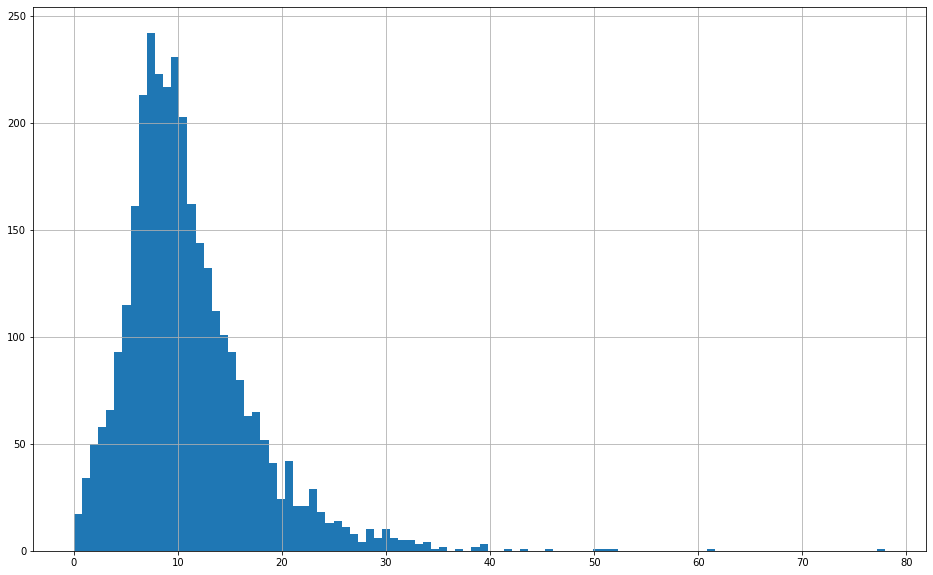

In [30]:
df_gas['Газ 1'].hist(bins=100, figsize=(16,10))

Поменяем имена столбцов

In [31]:
df_gas.columns = ['key', 'gas_1']

Посмотрим какое количество итераций встречается

In [32]:
df_gas['key'].value_counts().unique()

array([1])

#### Результаты измерения температуры

In [33]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [34]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Посмотрим какое количество итераций встречается

In [35]:
df_temp['key'].value_counts().unique()

array([17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

<AxesSubplot:>

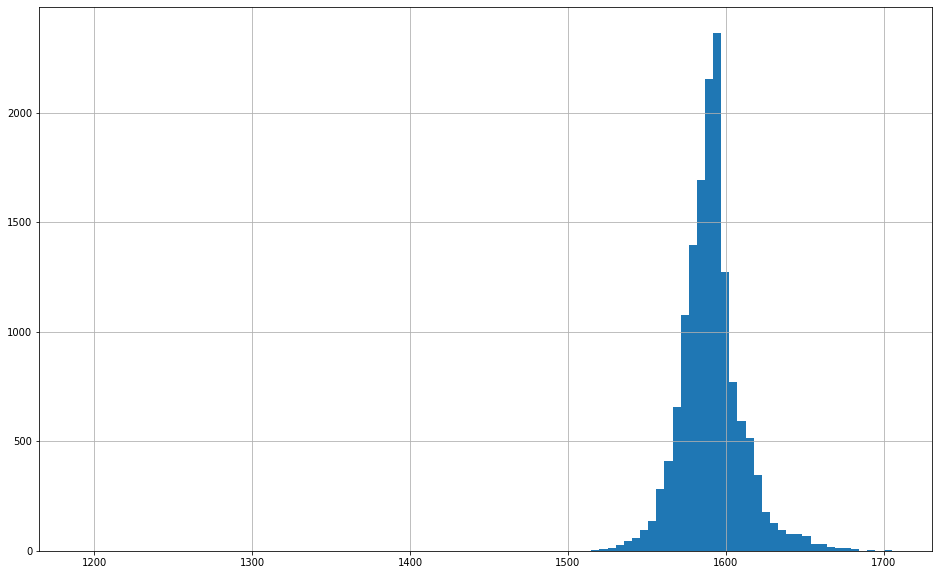

In [36]:
df_temp['Температура'].hist(bins=100, figsize=(16,10))

In [37]:
df_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Произведем группировку по KEY и оставим значения первого и последнего замера

In [38]:
df_temp = df_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])
df_temp.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']
df_temp.head(5)

,time_first,time_last,temp_first,temp_last
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


Удалим строки где была всего одна итерация или первый и последний замер совпадает

In [39]:
df_temp = df_temp[df_temp['temp_first'] != df_temp['temp_last']]

#### Данные о проволочных материалах (объём)

In [40]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Посмотрим какое количество итераций встречается

In [41]:
df_wire['key'].value_counts().unique()

array([1])

In [42]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Поменяем имена столбцов

In [44]:
df_wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

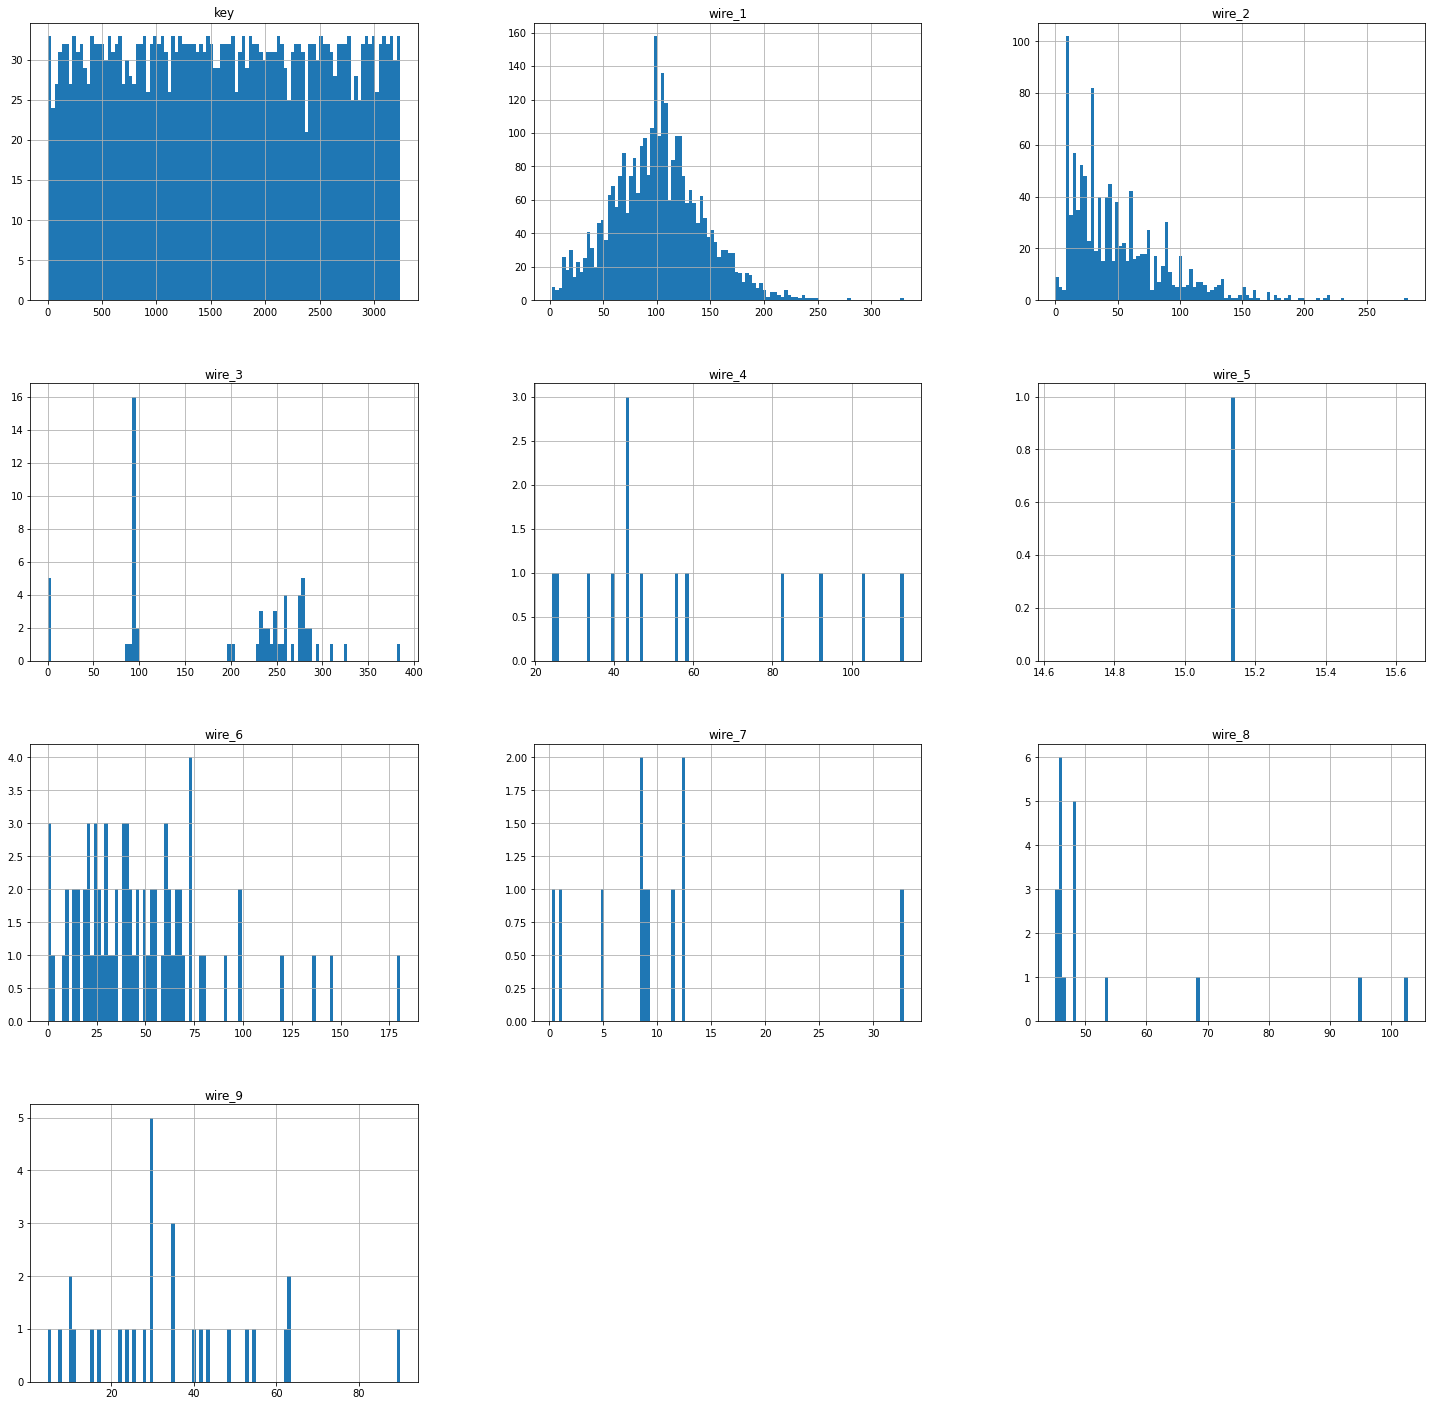

In [45]:
df_wire.hist(bins=100, figsize=(25,25));

#### Данные о проволочных материалах (время)

In [46]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Посмотрим какое количество итераций встречается

In [47]:
df_wire_time['key'].value_counts().unique()

array([1])

In [48]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поменяем имена столбцов

In [49]:
df_wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

После 1 этапа можно сделать следующие выводы:

В датасетах имеются пропуски. Они могут быть по разным причинам от особенности технологического производства до ошибки датчиков.

Объединить датасеты в один по столбцу key

Имена столбцов нужно превести на английский язык.

Целевым признаком будет последний замер температуры в df_temp

### Подготовка таблицы для обучения

Произведем слияние таблиц по ключу KEY

In [50]:
data = df_temp.merge(right=df_arc, how='inner', on='key')

In [51]:
data = data.merge(right=df_bulk, how='inner', on='key')

In [52]:
data = data.merge(right=df_gas, how='inner', on='key')

In [53]:
data = data.merge(right=df_wire, how='inner', on='key')

In [54]:
data.head(3)

,key,time_first,time_last,temp_first,temp_last,active_power,reactive_power,all_time,full_power,bulk_1,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,3.036730,2.142821,1098,3.718736,NaN,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,2.139408,1.453357,811,2.588349,NaN,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,4.063641,2.937457,655,5.019223,NaN,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заменим все пропуски на 0

In [55]:
data = data.fillna(0)

Столбец KEY сделаем INDEX

In [56]:
data = data.set_index('key')

Проверим признаки на мультиколлинеарность

In [57]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,temp_first,temp_last,active_power,reactive_power,all_time,full_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
temp_first,1.000000,0.247758,-0.122739,-0.123289,-0.309426,-0.123175,0.073896,0.120302,-0.104162,0.142999,0.068947,-0.095032,0.075107,-0.009264,-0.026013,0.035791,-0.087717,-0.061164,0.018910,-0.132640,-0.041960,0.037686,0.207442,-0.084844,0.000232,0.065347,nan,0.020325,0.044967,-0.023055,0.004645
temp_last,0.247758,1.000000,0.173775,0.168563,0.276022,0.172191,-0.074559,-0.083292,-0.036533,0.184636,-0.028678,-0.179633,-0.108353,-0.026855,-0.016259,0.061691,-0.110517,0.265241,-0.011054,0.113165,0.266348,0.058063,0.313493,-0.206883,-0.048049,-0.161311,nan,-0.084906,-0.138618,-0.010898,-0.027792
active_power,-0.122739,0.173775,1.000000,0.992446,0.721637,0.999033,0.102407,0.091493,0.100040,0.002618,0.073466,0.135105,0.146445,-0.025655,0.027288,0.008036,0.070390,0.285134,0.105748,0.301258,0.167875,0.371061,0.136508,0.064633,0.054862,0.103658,nan,0.056359,0.061786,0.034535,-0.023906
reactive_power,-0.123289,0.168563,0.992446,1.000000,0.713474,0.996877,0.098819,0.088116,0.097824,0.002103,0.072682,0.134172,0.144031,-0.025817,0.022405,0.005693,0.069483,0.284851,0.103397,0.297237,0.166447,0.368092,0.136888,0.063831,0.055732,0.102089,nan,0.054209,0.067243,0.029064,-0.020478
all_time,-0.309426,0.276022,0.721637,0.713474,1.000000,0.719999,0.104844,0.038144,0.091713,-0.030722,0.013106,0.163627,0.084889,-0.011452,0.012727,-0.013147,0.085539,0.464815,0.129793,0.461021,0.295149,0.397048,0.052769,0.055739,0.033129,0.054883,nan,0.042085,0.027666,0.017690,-0.012050
full_power,-0.123175,0.172191,0.999033,0.996877,0.719999,1.000000,0.101301,0.090476,0.099460,0.002429,0.073342,0.134933,0.145826,-0.025729,0.025605,0.007183,0.070141,0.285506,0.105096,0.300335,0.167640,0.370645,0.136913,0.064476,0.055234,0.103291,nan,0.055713,0.063870,0.032658,-0.022635
bulk_1,0.073896,-0.074559,0.102407,0.098819,0.104844,0.101301,1.000000,0.226159,-0.010652,0.041917,0.060744,-0.005339,0.238760,-0.005780,-0.019948,-0.023044,-0.037009,0.327637,-0.010411,0.208215,-0.000323,0.239360,0.015794,-0.011764,0.020315,0.147235,nan,0.149481,0.083979,-0.019725,0.011065
bulk_2,0.120302,-0.083292,0.091493,0.088116,0.038144,0.090476,0.226159,1.000000,-0.047407,0.041288,0.360219,-0.030261,0.679332,-0.001570,-0.005417,-0.018235,0.001837,-0.099758,-0.005681,-0.141981,-0.106577,0.218583,-0.170400,-0.039388,0.223100,0.699320,nan,0.558837,0.431723,-0.005357,-0.006950
bulk_3,-0.104162,-0.036533,0.100040,0.097824,0.091713,0.099460,-0.010652,-0.047407,1.000000,-0.294200,-0.007302,0.066254,-0.033898,0.020839,0.011106,-0.085609,-0.008658,0.018912,-0.013751,0.010684,-0.013031,0.057472,0.040465,0.096544,0.005347,-0.040974,nan,0.006699,-0.019663,0.004588,0.004278
bulk_4,0.142999,0.184636,0.002618,0.002103,-0.030722,0.002429,0.041917,0.041288,-0.294200,1.000000,0.028852,-0.250883,0.046405,-0.013239,-0.002791,-0.085481,-0.117665,0.104344,0.003414,-0.090557,0.102593,0.016853,0.295424,-0.266983,-0.039247,0.034843,nan,-0.011236,0.034164,0.008061,-0.058371


Удалим столбцы которые нам мешают

In [58]:
data = data.drop(['active_power', 'reactive_power', 'time_first', 'time_last','wire_8', 'wire_5'], axis = 1)

In [59]:
data.head()

,temp_first,temp_last,all_time,full_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_14,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1098,3.718736,0.0,0.0,0.0,43.0,0.0,0.0,...,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,811,2.588349,0.0,0.0,0.0,73.0,0.0,0.0,...,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,655,5.019223,0.0,0.0,0.0,34.0,0.0,0.0,...,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,741,3.400038,0.0,0.0,0.0,81.0,0.0,0.0,...,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,869,2.816980,0.0,0.0,0.0,78.0,0.0,0.0,...,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0


Разобъём данные на train и test

In [60]:
train, test = train_test_split(data, test_size = 0.25, random_state = RND)

In [61]:
features_train = train.drop(['temp_last'], axis = 1)
target_train = train['temp_last']
features_test = test.drop(['temp_last'], axis = 1)
target_test = test['temp_last']

### Обучение модели

#### RandomForestRegressor

In [62]:
%%time

model2 = RandomForestRegressor(random_state=RND)

model2_parametrs = { 'n_estimators': range(5, 15, 5),
                     'max_depth': range(1, 6, 2),
                     'min_samples_leaf': range(1,4),
                     'min_samples_split': range(2,6,2) }

model2_grid = GridSearchCV(model2, model2_parametrs, scoring='neg_mean_absolute_error', cv=5)

model2_grid.fit(features_train, target_train)

model2_grid.refit_time_

CPU times: user 4.46 s, sys: 22.3 ms, total: 4.48 s
Wall time: 4.49 s


0.04183244705200195

In [63]:
%%time

model2_params = model2_grid.best_params_

model2_score = model2_grid.best_score_ * (-1)

print(model2_params)
print(model2_score)

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
6.586610724367878
CPU times: user 192 µs, sys: 12 µs, total: 204 µs
Wall time: 140 µs


#### CatBoostRegressor

In [65]:
%%time

model3 = CatBoostRegressor(random_state=RND)

model3_parametrs = {"iterations": [100],
                "depth": range(8, 16, 2),
                "learning_rate" : [0.15]
             }

model3_grid = GridSearchCV(model3, model3_parametrs, scoring='neg_mean_absolute_error', cv=5)

model3_grid.fit(features_train, target_train, verbose=10)

0:	learn: 10.9634527	total: 66.4ms	remaining: 6.57s
10:	learn: 8.5377973	total: 167ms	remaining: 1.35s
20:	learn: 7.6878952	total: 282ms	remaining: 1.06s
30:	learn: 7.1550255	total: 391ms	remaining: 871ms
40:	learn: 6.7758374	total: 499ms	remaining: 718ms
50:	learn: 6.4454410	total: 609ms	remaining: 585ms
60:	learn: 6.1259815	total: 748ms	remaining: 478ms
70:	learn: 5.6902721	total: 881ms	remaining: 360ms
80:	learn: 5.3782734	total: 1.03s	remaining: 241ms
90:	learn: 5.1287602	total: 1.14s	remaining: 113ms
99:	learn: 4.9252917	total: 1.24s	remaining: 0us
0:	learn: 10.6728459	total: 12.7ms	remaining: 1.26s
10:	learn: 8.4672048	total: 127ms	remaining: 1.03s
20:	learn: 7.6331505	total: 250ms	remaining: 940ms
30:	learn: 7.1030303	total: 359ms	remaining: 798ms
40:	learn: 6.6570552	total: 465ms	remaining: 669ms
50:	learn: 6.2930185	total: 569ms	remaining: 547ms
60:	learn: 5.9702582	total: 673ms	remaining: 430ms
70:	learn: 5.6352864	total: 786ms	remaining: 321ms
80:	learn: 5.3319921	total: 895

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4feb2f5a30>,
             param_grid={'depth': range(8, 16, 2), 'iterations': [100],
                         'learning_rate': [0.15]},
             scoring='neg_mean_absolute_error')

In [66]:
%%time

model3_params = model3_grid.best_params_

model3_score = model3_grid.best_score_ * (-1)

print(model3_params)
print(model3_score)

{'depth': 8, 'iterations': 100, 'learning_rate': 0.15}
6.329493612937563
CPU times: user 291 µs, sys: 67 µs, total: 358 µs
Wall time: 184 µs


#### LGBMRegressor

In [68]:
%%time

model4 = LGBMRegressor()

model4_parametrs = {'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1]}

model4_grid = GridSearchCV(model4, model4_parametrs, scoring='neg_mean_absolute_error', cv=3)
model4_grid.fit(features_train, target_train)

CPU times: user 8min 6s, sys: 5.05 s, total: 8min 11s
Wall time: 8min 14s


GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1], 'num_leaves': [31, 100, 200]},
             scoring='neg_mean_absolute_error')

In [69]:
%%time

model4_params = model4_grid.best_params_

model4_score = model4_grid.best_score_ * (-1)

print(model4_params)
print(model4_score)

{'learning_rate': 0.1, 'num_leaves': 31}
6.5044376163232736
CPU times: user 1.11 ms, sys: 125 µs, total: 1.24 ms
Wall time: 889 µs


#### Итоговая табличка метрик на трайне

In [72]:
results = {
    'Model' : ['RandomForestR', 'CatBoostRegressor', 'LGBMRegressor'],

    'MAE train': pd.Series([model2_score, model3_score, model4_score])
    

    }
display(pd.DataFrame(results))

,Model,MAE train
0,RandomForestR,6.586611
1,CatBoostRegressor,6.329494
2,LGBMRegressor,6.504438


### Тестирование лучшей модели на тесте

В итоговой таблице видим что лучший показатель у модели CatBoostRegressor, проверим ее на test'e

In [90]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**model3_params)
model.fit(features_train, target_train)
model_predict = model.predict(features_test)
print("MAE on test: ", mean_absolute_error(target_test, model_predict))

MAE on test:  6.006395677483939
CPU times: user 1.26 s, sys: 4.51 ms, total: 1.26 s
Wall time: 1.87 s


Посмотрим на значимость признаков

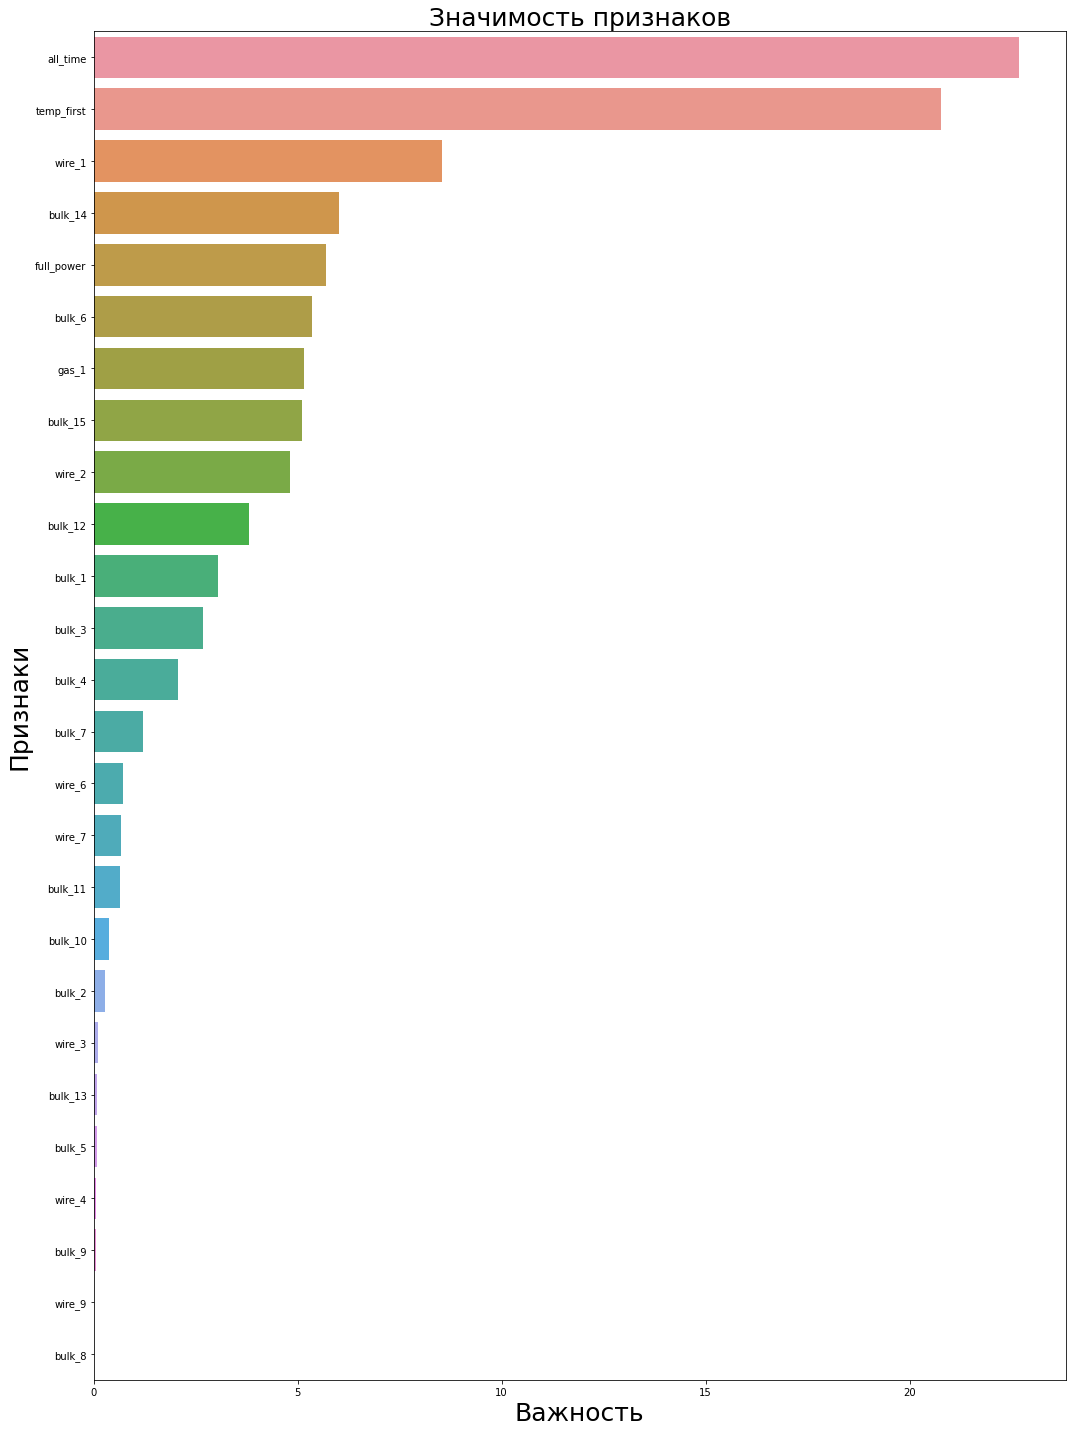

In [107]:
importances = model.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
#feature_results
plt.figure(figsize=(15, 20))
sns.barplot(x="importance", y="feature", data=feature_results)
plt.title('Значимость признаков', fontsize=25)
plt.ylabel('Признаки', fontsize=25)
plt.xlabel('Важность', fontsize=25)
plt.tight_layout()
plt.show()

В ходе работы над проектом мы выполнели работу по подготовке данных. Изменили тип данных для подсчета общего времени итераций, сгруппировали данные по партиям. Подготовели признаки. Сделали итоговую общую таблицу для обучения модели. Определили целевым признаком последний замер температуры. Для обучения выбрали три модели RandomForestRegressor, CatBoostRegressor, LGBMRegressor. Лучшей моделью на трейне по метрике MAE = 6.329 стал CatBoostRegressor. Проверили на тесте CatBoostRegressor показал MAE = 6.006. Получается модель в среднем ошибается на 6 градусов.